### **Adversarial AI: Reproducing "Synthesis and Reconstruction of Fingerprints using GANs"**


Submitted by: Sapir Anidgar, Gil Lifshits, Yarin Benyamin, Avihai Edri


# **1. Setup: Virtual Environment & Dependencies**

This section sets up the virtual environment and installs all necessary dependencies.


In [ ]:
# Activate the virtual environment
!source activate oai

In [ ]:
# Install dependencies
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install tqdm
!pip install PyYAML

# Convert YAML dependencies to pip format and install
!python environment/yml2pip.py

# **2. Dataset Preparation**

Since NIST SD14 is no longer available, we use the SOCOFing dataset as a comparable alternative.


In [ ]:
# Extract and modify the dataset paths accordingly
!python unzip.py
!python change_paths.py

# **3. Train the Initial Model (StyleGAN-based Fingerprint Generator)**


A GAN has two parts: a generator that creates fake data and a discriminator that tries to detect if it's real or fake. They compete, improving the generator's ability to make realistic data.

StyleGAN is a version of GAN that separates high-level features from fine details, progressively growing the model for stable, high-quality images, in our case a more realistic fingerprints.


In [ ]:
# Start the training (output stylegan_weights)
!python training.py --exp_dir=output --is_gray

In the next graphs we can see the generator train part where:
- path is the path length regularization loss (latent space is learning stable representations)
- mean path is the average path length
- d is the discriminator loss
- r1 is the R1 regularization loss
- augment is the adaptive augmentation probability
- g is the generator loss (If we need more diversity it will be greater than 0)


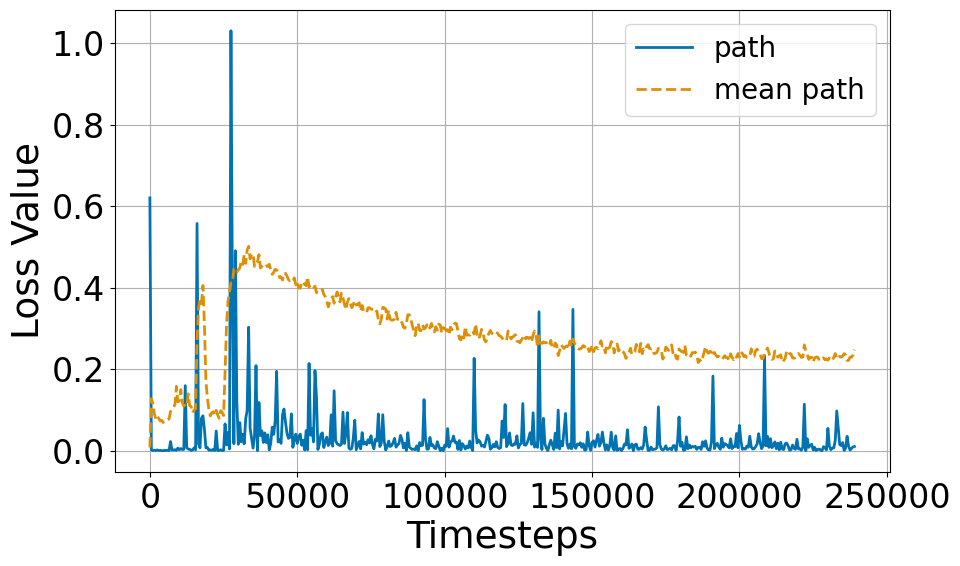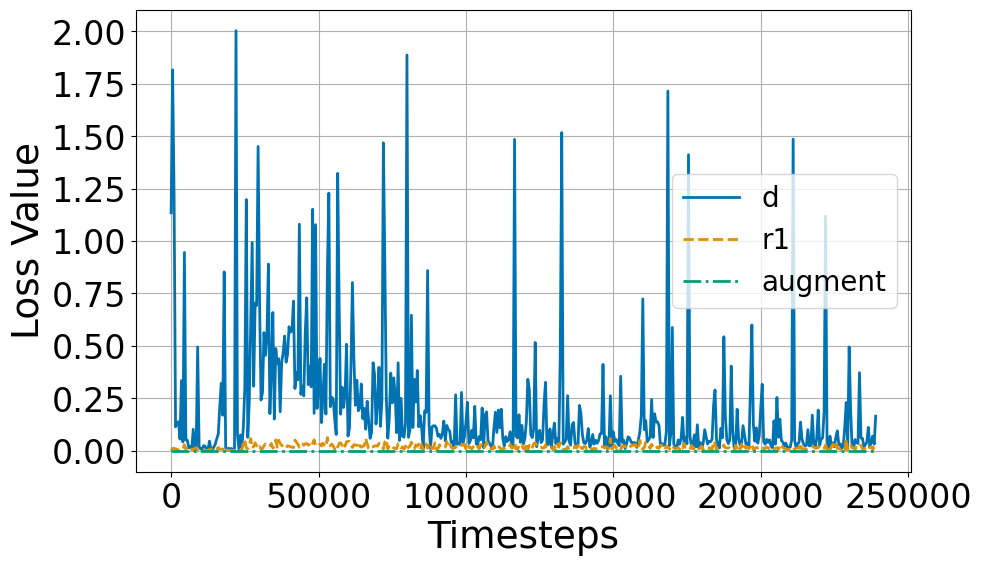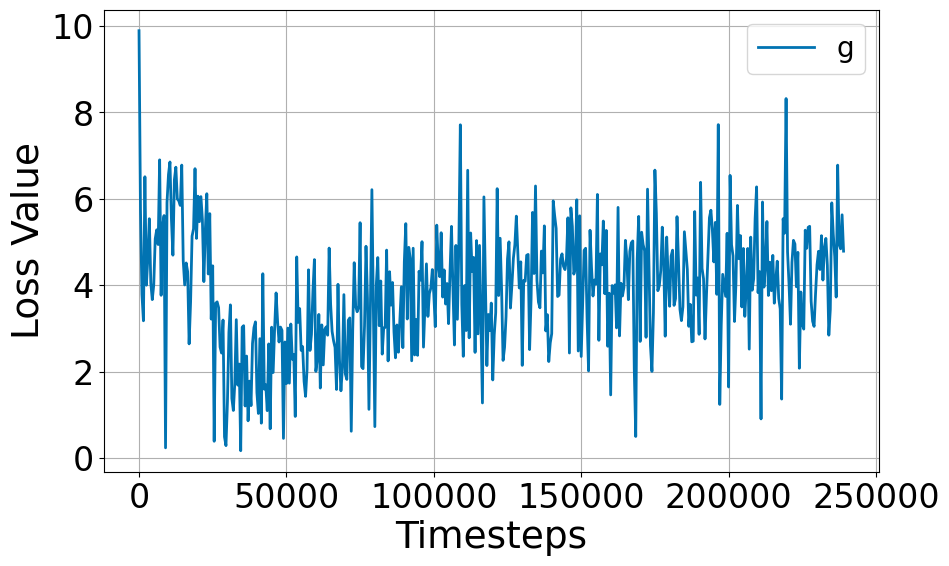

# **4. Generate Synthetic Fingerprints**

Once the model is trained, we generate synthetic fingerprint samples
using the trained generator.


In [ ]:
# Generate examples
!python inference.py --exp_dir=mnt1 --is_gray --n_images=200
!python inference.py --exp_dir=mnt2 --is_gray --n_images=50

# **5. Download Pretrained Models for Reconstruction**

To reconstruct fingerprints, we use pre-trained models:
- **FingerNet:** Helps preserve fingerprint identity in reconstruction.
- **Encoder Pretrained Model:** Assists in minutiae extraction and encoding.


In [ ]:
# Download rest of the model weights
!mkdir pretrained_models && cd pretrained_models
# fingernet
!wget -O Model.model https://raw.githubusercontent.com/alkarnjn/FingerNet/master/models/released_version/Model.model
# encoder_pretrained
!wget -O best_model.pt https://www.dropbox.com/scl/fi/ji4ca9js46oqdh023g8ck/best_model.pt?rlkey=7lnvs5nbuzgyzy4xme4odkp6g&e=1&dl=0
!cd ..

# **6. Train the Minutiae-Based Reconstruction Model**

This model reconstructs fingerprints from extracted minutiae information.
It ensures that synthesized fingerprints maintain realistic attributes.


In [ ]:
# Start the training (output the mnt model)
!python 2nd_train.py

In the next graph we can see the mnt train part where:

- loss_l2 is the mean squared error
- loss_lpips is the learned perceptual image patch similarity metric (measuring high-level differences in feature space)
- loss is the fingernet loss plus the total loss

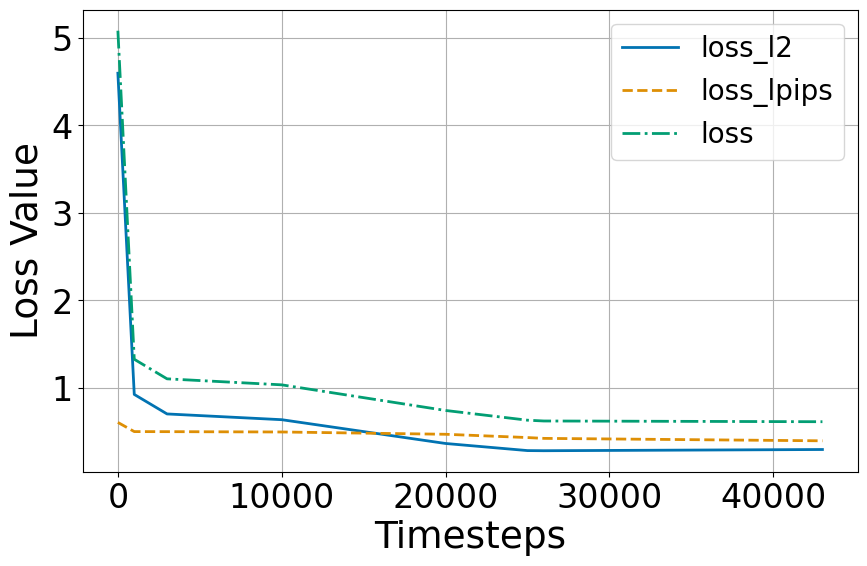

## **7. Results & Evaluation**

We evaluate our framework based on:
- **Frechet Inception Distance (FID):** Measures the quality of generated fingerprints.
- **NIST Finger Image Quality (NFIQ 2.0):** Assesses fingerprint clarity & quality.
- **Verification and Identification Tests:** Compare Type-I and Type-II attack success rates.


### **Fingerprint Synthesis Validity**

#### **FID Score**
We computed the FID score for the synthesized dataset and found that the Frechet Inception Distance between the generated and real fingerprint image distributions is **71.55**.

#### **NFIQ 2 Score**
We analyzed the distribution of NFIQ 2 scores (lower is better) for the synthesized dataset and compared it with the real images' distribution. The results are summarized in the table below.

The results indicate that the generated dataset closely matches the quality score distribution of real images, suggesting that the synthesized dataset maintains a quality level comparable to real fingerprints.



            Dataset    Mean  Std. Dev.
0          SOCOFing  56.770      17.49
1  Our Reproduction  58.645      16.21


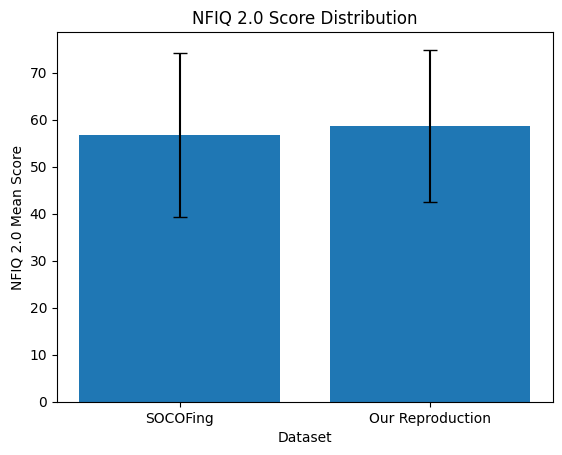

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data for NFIQ 2.0 score distribution
nfiq_data = {
    "Dataset": ["SOCOFing", "Our Reproduction"],
    "Mean": [56.77, 58.645],
    "Std. Dev.": [17.49, 16.21]
}

# Create DataFrame
nfiq_df = pd.DataFrame(nfiq_data)
print(nfiq_df)

# Plot the distributions
plt.bar(nfiq_df["Dataset"], nfiq_df["Mean"], yerr=nfiq_df["Std. Dev."], capsize=5)
plt.xlabel("Dataset")
plt.ylabel("NFIQ 2.0 Mean Score")
plt.title("NFIQ 2.0 Score Distribution")
plt.show()

### **Fingerprint Reconstruction Verification**

The following table presents the verification scores for each examined False Acceptance Rate (FAR) for Type-I and Type-II attacks. The FAR values used in our experiments are higher than those in the original paper. Even at larger FAR values, our calculations show extremely low verification scores.

The results suggest that both attack types fail to deceive a fingerprint recognition system with a good verification score. The dataset generated using the NIST SD14-based framework (SynFing dataset) more accurately mimics real fingerprint impressions than our dataset generated using the SOCOFing dataset.


   FAR (%)  Type-I Attack (%)  Type-II Attack (%)
0      0.1               0.00                0.00
1      1.0               3.37                1.12
2     10.0              12.36                8.99


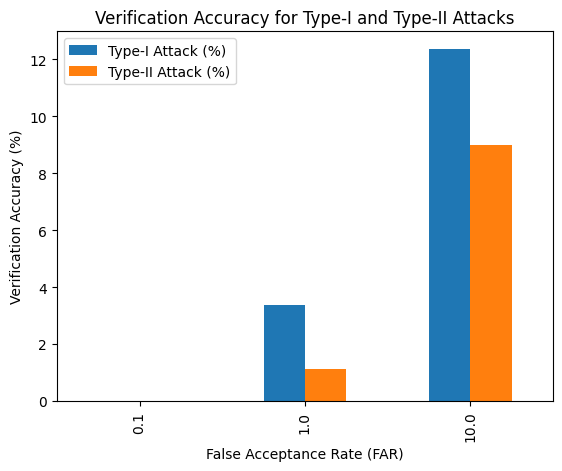

In [ ]:
# Data for verification accuracy
verification_data = {
    "FAR (%)": [0.1, 1, 10],
    "Type-I Attack (%)": [0.00, 3.37, 12.36],
    "Type-II Attack (%)": [0.00, 1.12, 8.99]
}

# Create DataFrame
verification_df = pd.DataFrame(verification_data)
print(verification_df)

# Plot the verification accuracy
verification_df.plot(x="FAR (%)", kind="bar", stacked=False)
plt.xlabel("False Acceptance Rate (FAR)")
plt.ylabel("Verification Accuracy (%)")
plt.title("Verification Accuracy for Type-I and Type-II Attacks")
plt.legend(loc="upper left")
plt.show()
